## How Neural Style Transfer (NST) Works
Neural Style Transfer (NST) is a technique that combines the content of one image with the artistic style of another using a pre-trained convolutional neural network (CNN). The key idea is to separate content and style features in deep layers of a CNN and then recombine them.

NST uses an optimization-based approach where:

- The content image defines the structure.
- The style image provides the artistic texture.
- A randomly initialized image (or a copy of the content image) is optimized to minimize the difference in content with the content image and the difference in style with the style image.


In [91]:
import torch

import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from torchvision import transforms
from torchvision.models import VGG19_Weights
from torchvision.utils import save_image

#### Pick device that is more suitable to run the algorithm

In [33]:
# device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
# Use Metals backend if available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

#### Define model hyperparameters

In [34]:
# this is the size that was used to train VGG19 model. 
# it's possible to use larger image resolution, however then the optimisation process takes more time
IMAGE_SIZE = 224
# how many times the algorithm tries to "optimise" the loss
EPOCHS = 20001
# this essentially affects the speed of the optimisation process
# as in regression models, here it affects the "step size" towards the function's extremum
LEARNING_RATE = 0.001
# Alpha and Beta defines how much content and style loss functions contribute to the total loss.
# The formula and implementation for the total loss will be given below, so it should be much clearer what
# role do they play in the algorithm
ALPHA = 1
BETA = 1000

#### Image loading and preprocessing

Before we start working with image, they need to be preprocessed.
The `load_image` function define processing 3 stages:
1) Resizing image to fit original VGG19 input
2) Converts it to PyTorch tensor
3) Normalises RGB values, for this it uses predefined values from ImageNet - the dataset,
   that has been used to train VGG19. This step effectivaly "standartise" values and ensures faster optmization process (or convergence if a model is trained from scratch). [This video](https://www.youtube.com/watch?v=sxEqtjLC0aM) explains very well the difference between normalisation and standartization

Finally using `unsqueeze` method it adds the "batch" dimention. This is needed as PyTorch expects to consume multiple entities, in this case images at once (even tho in this case each batch will contain a single image)

In [100]:
# VGG19 mean and starndart deviation for RGB values
rgb_mean = [0.485, 0.456, 0.406]
rgb_std = [0.229, 0.224, 0.225]

In [101]:
def load_image(filename):
    transform = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=rgb_mean, std=rgb_std)
    ])

    image = Image.open(filename)
    processed_image = transform(image)
    return processed_image.unsqueeze(0) # unsqueeze adds the batch dimention

In [102]:
def display(image):
    plt.imshow(image.permute(0, 2, 3, 1).squeeze().to('cpu'))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


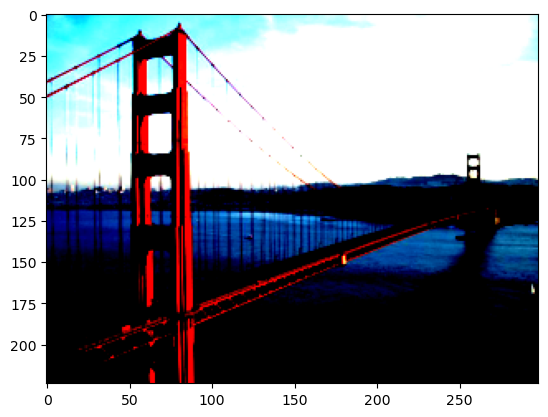

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


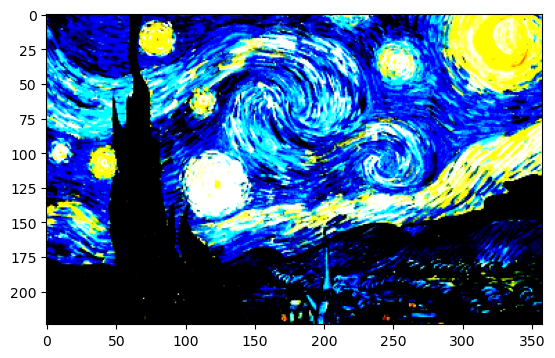

In [103]:
content_image = load_image('./img/content/golden_gate.jpg').to(device)
style_image = load_image('./img/style/starry_night.jpg').to(device)
# Use content image to initialise generated image
# `requires_grad` is used to allow image pixels to be modified during backprop
gen_image = content_image.clone().requires_grad_(True)
display(content_image)
display(style_image)

#### Modifying the VGG-19 model

In [104]:
model = models.vgg19(weights=VGG19_Weights.IMAGENET1K_V1)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

#### TBD: modified VGG description (layers, and forward pass)

In [105]:
class ModifiedVGG(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_context_idx = [21] # conv41
        self.layer_style_idx = [0, 5, 10, 19, 28] #conv11, conv21, conv31, conv41, conv51
        # we don't take hire levels into consideration
        self.model = models.vgg19(weights=VGG19_Weights.IMAGENET1K_V1).features[:29]

    def forward(self, x):
        content_features = []
        style_features = []

        for layer_idx, layer in enumerate(self.model):
            x = layer(x)
            if layer_idx in self.layer_context_idx:
                content_features.append(x)
            if layer_idx in self.layer_style_idx:
                style_features.append(x)

        return content_features, style_features

Let's test our modifed VGG model
One thing to notice that the mode is not trained any further.
Hence we need to freeze weights using the `eval` method

In [106]:
modified_vgg = ModifiedVGG().to(device).eval() # init model and freeze weights
content_features = modified_vgg(content_image)[0]
style_features = modified_vgg(style_image)[1]

print('content_features length: ', len(content_features))
print('style_features length: ', len(style_features))

content_features length:  1
style_features length:  5


#### Peek inside generated feature maps

Lets display constent features maps to see that is inside

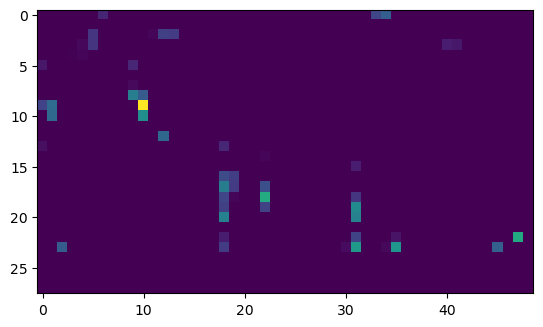

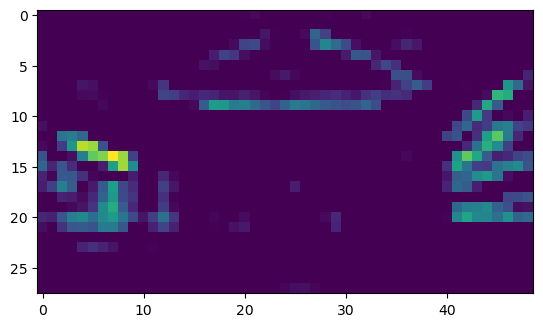

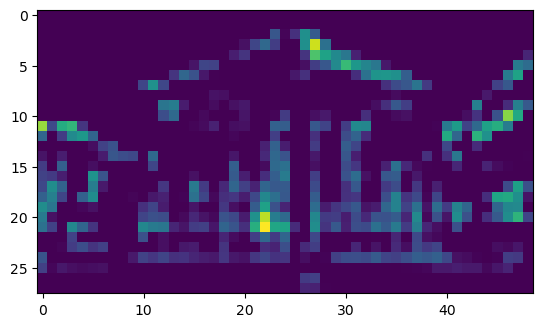

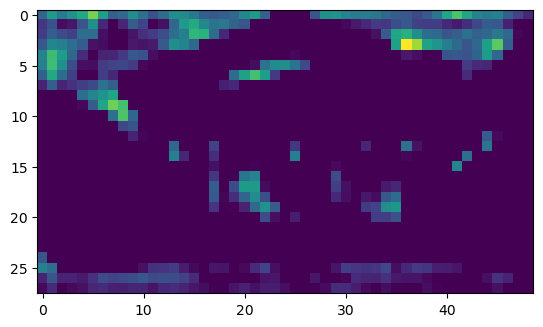

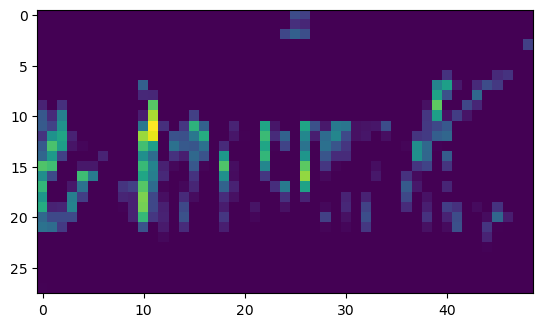

In [67]:
plt.imshow(content_features[0].permute(0, 2, 3, 1).squeeze()[:,:,0].to('cpu').detach())
plt.show()

plt.imshow(content_features[0].permute(0, 2, 3, 1).squeeze()[:,:,1].to('cpu').detach())
plt.show()

plt.imshow(content_features[0].permute(0, 2, 3, 1).squeeze()[:,:,2].to('cpu').detach())
plt.show()

plt.imshow(content_features[0].permute(0, 2, 3, 1).squeeze()[:,:,3].to('cpu').detach())
plt.show()

plt.imshow(content_features[0].permute(0, 2, 3, 1).squeeze()[:,:,4].to('cpu').detach())
plt.show()

Same approach can be used to display style image features maps

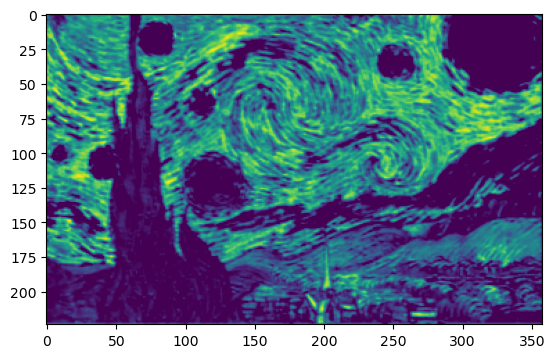

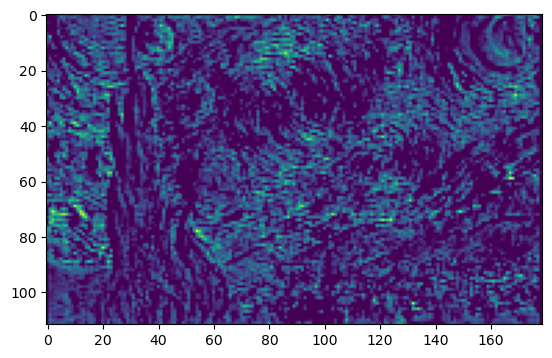

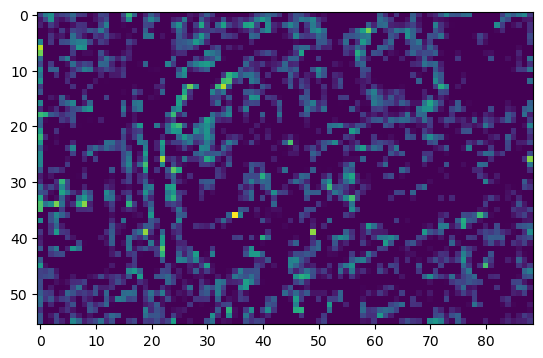

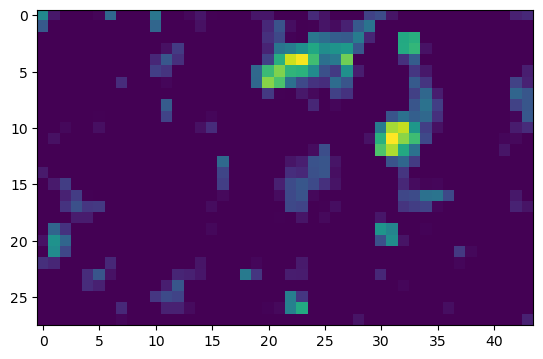

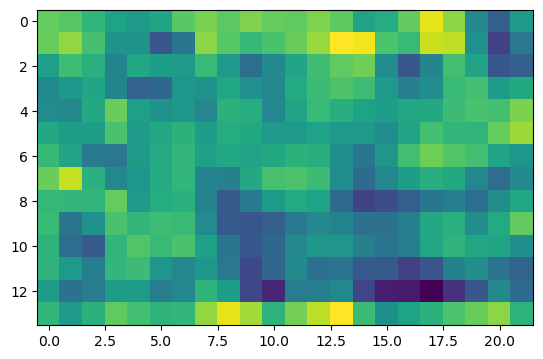

In [68]:
# Codeblock 11
plt.imshow(style_features[0].permute(0, 2, 3, 1).squeeze()[:,:,60].to('cpu').detach())
plt.show()

plt.imshow(style_features[1].permute(0, 2, 3, 1).squeeze()[:,:,12].to('cpu').detach())
plt.show()

plt.imshow(style_features[2].permute(0, 2, 3, 1).squeeze()[:,:,71].to('cpu').detach())
plt.show()

plt.imshow(style_features[3].permute(0, 2, 3, 1).squeeze()[:,:,152].to('cpu').detach())
plt.show()

plt.imshow(style_features[4].permute(0, 2, 3, 1).squeeze()[:,:,76].to('cpu').detach())
plt.show()

#### Creating the Gram Matrix
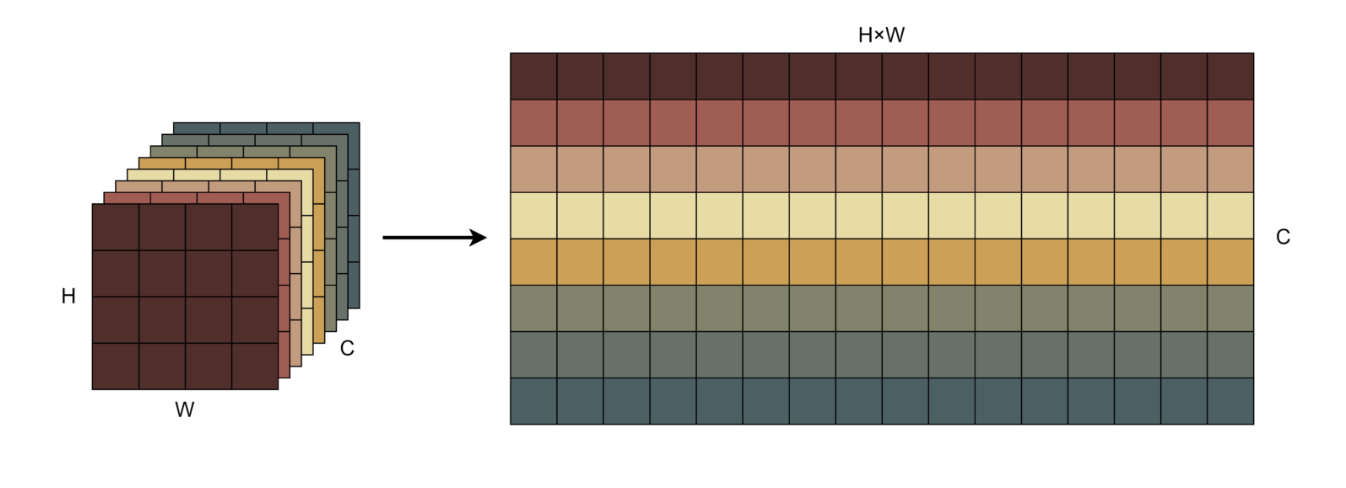
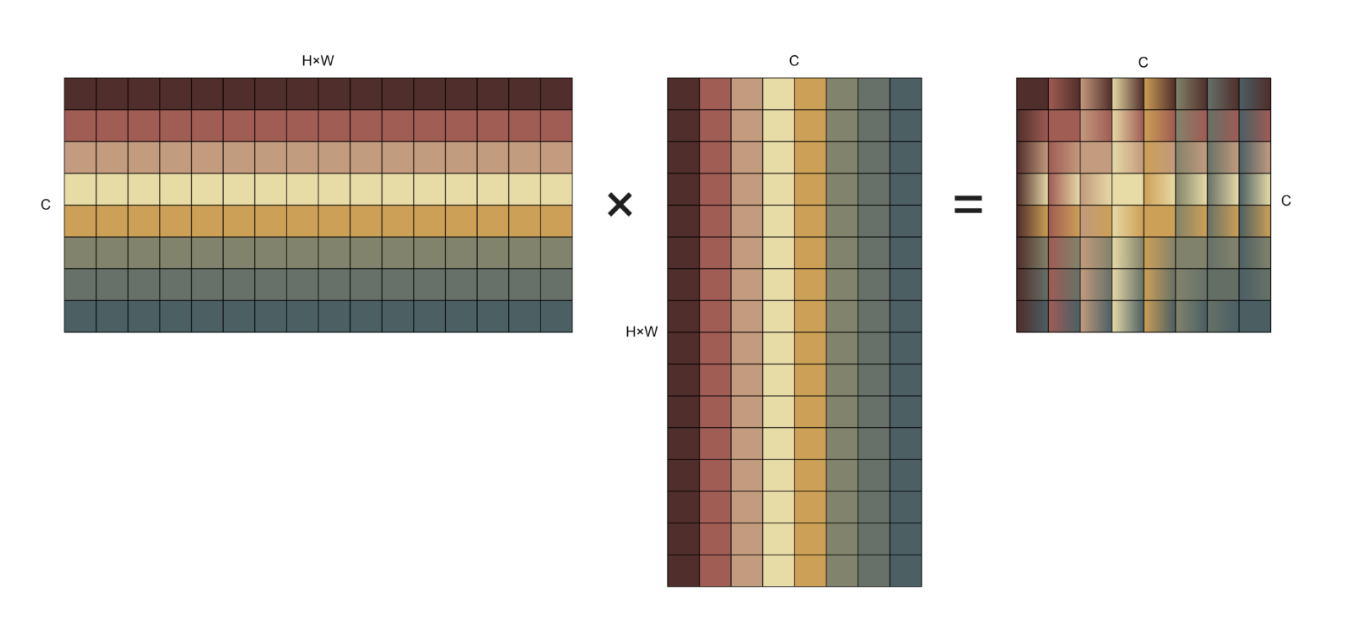

In [107]:
def compute_gram_matrix(feature_map):
    batch_size, num_channels, height, width = feature_map.shape
    feature_map_flat = feature_map.view(num_channels, height * width)
    gram_matrix = torch.matmul(feature_map_flat, feature_map_flat.t())
    return gram_matrix

Lets visualise gram matrices for some of the style feature maps

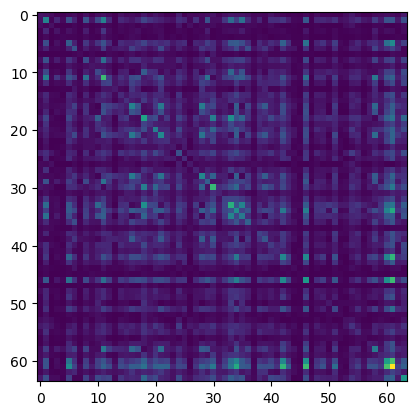

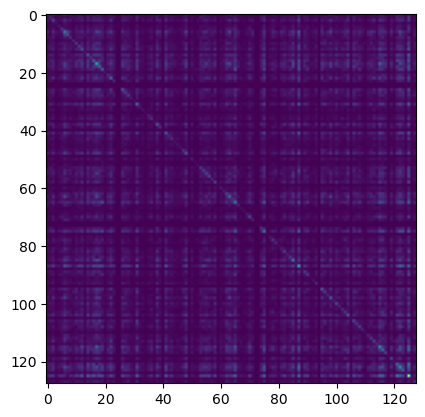

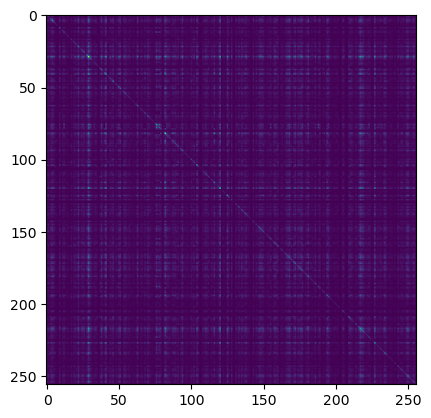

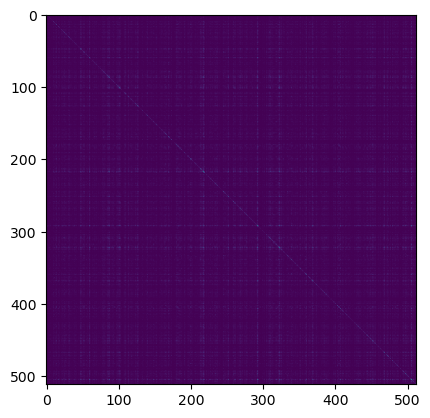

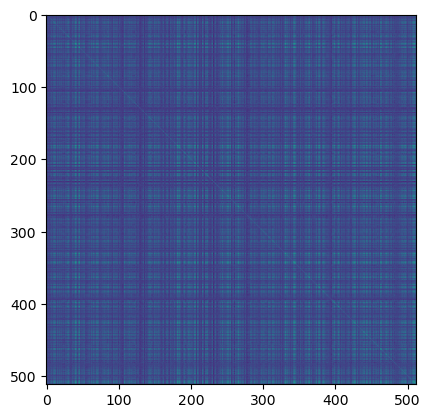

In [72]:
style_features_0 = compute_gram_matrix(style_features[0])
style_features_1 = compute_gram_matrix(style_features[1])
style_features_2 = compute_gram_matrix(style_features[2])
style_features_3 = compute_gram_matrix(style_features[3])
style_features_4 = compute_gram_matrix(style_features[4])

plt.imshow(style_features_0.to('cpu').detach())
plt.show()

plt.imshow(style_features_1.to('cpu').detach())
plt.show()

plt.imshow(style_features_2.to('cpu').detach())
plt.show()

plt.imshow(style_features_3.to('cpu').detach())
plt.show()

plt.imshow(style_features_4.to('cpu').detach())
plt.show()

#### Loss function and optimiser

In [108]:
def mse(tensor1, tensor2):
    return torch.mean((tensor1-tensor2)**2)

In [109]:
optimiser = optim.Adam(params=[gen_image], lr=LEARNING_RATE)

TODO: A small note on denormalisation (also make a note about .view call)

In [110]:
def denormalize(gen_image):
    mean = torch.tensor(rgb_mean, device=device).view(1, 3, 1, 1)
    std = torch.tensor(rgb_std, device=device).view(1, 3, 1, 1)
    gen_image = gen_image * std + mean
    return gen_image

In [111]:
def optimise():
    content_losses = []
    style_losses = []
    total_losses = []

    for epoch in tqdm(range(EPOCHS)):
        content_features = modified_vgg(content_image)[0]
        style_features = modified_vgg(style_image)[1]
        gen_content_features, gen_style_features = modified_vgg(gen_image)
        
        content_loss = 0
        style_loss = 0
        for content_feat, gen_content_feat in zip(content_features, gen_content_features):
            content_loss += mse(content_feat, gen_content_feat)

        for style_feat, gen_style_feat in zip(style_features, gen_style_features):
            style_gram = compute_gram_matrix(style_feat)
            gen_style_gram = compute_gram_matrix(gen_style_feat)
            style_loss += mse(style_gram, gen_style_gram)

        total_loss = ALPHA * content_loss + BETA * style_loss
        optimiser.zero_grad()
        total_loss.backward()
        optimiser.step()

        content_losses.append(content_loss.item())
        style_losses.append(style_loss.item())
        total_losses.append(total_loss.item())

        if epoch % 200 == 0:
            gen_denormalized = denormalize(gen_image)
            save_image(gen_denormalized, f'./img/gen/gen_image{epoch}.png')

    return content_losses, style_losses, total_losses

#### ... and now it's time to check the optimisation algorithm in action

In [113]:
content_losses, style_losses, total_losses = optimise()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20001/20001 [1:47:16<00:00,  3.11it/s]


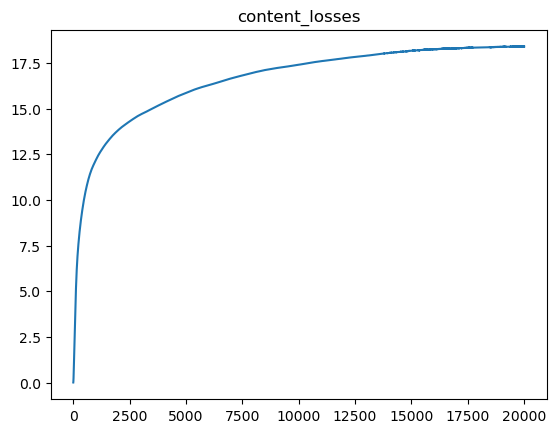

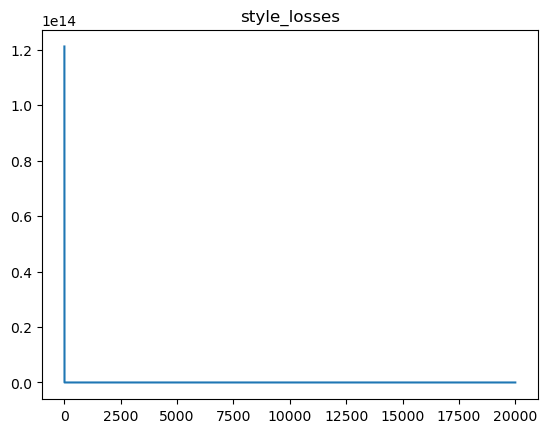

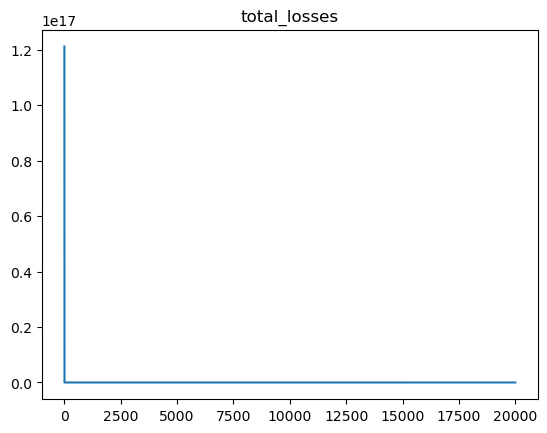

In [114]:
plt.title('content_losses')
plt.plot(content_losses)
plt.show()

plt.title('style_losses')
plt.plot(style_losses)
plt.show()

plt.title('total_losses')
plt.plot(total_losses)
plt.show()

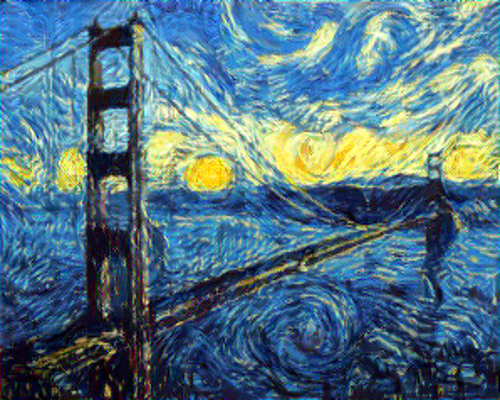

In [123]:
Image.open('./img/gen/gen_image20000.png').resize((500, 400))

#### Reference materials

[The nootbook is heavily based on the following article](https://towardsdatascience.com/paper-walkthrough-neural-style-transfer-fc5c978cdaed/)